# Convolutional Neural Networks (CNNs)

# Flowers dataset

#### Classes: daisy, dandelion, roses, sunflowers, tulips

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adagrad, RMSprop, Adam


import torchvision
from torchvision import models
from sklearn.model_selection import ParameterSampler

import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Part One

## STEP 1

In [5]:
# Set a random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

In [6]:
# Augmentation and preprocessing, done in step 1 for data loading purposes
train_transforms = transforms.Compose([transforms.Resize((299,299)),
                                       transforms.RandomRotation(degrees=20),
                                       transforms.RandomHorizontalFlip(1),
                                       transforms.ToTensor()
                                       ])

test_transforms = transforms.Compose([transforms.Resize((299,299)),
                                      transforms.ToTensor()
                                      ])

# Data loading
train_dataset = datasets.ImageFolder('/kaggle/input/flowers/train', transform=train_transforms)
test_dataset = datasets.ImageFolder('/kaggle/input/flowers/test', transform=test_transforms)


## STEP 2

In [7]:
# train-val split
train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size],generator=torch.Generator().manual_seed(random_seed))

val_subset.dataset.transform = test_transforms

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## STEP 1 SAMPLE

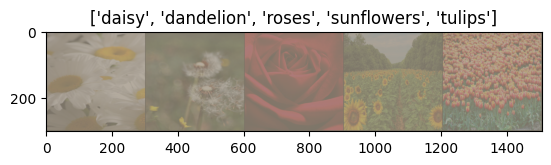

In [8]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


class_examples = {}
class_names = train_dataset.classes  # Get the list of class names

# Sample one batch from the DataLoader
inputs, classes = next(iter(train_loader))

# Iterate over the batch to gather one sample per class
for img, label in zip(inputs, classes):
    class_examples[label.item()] = img

# Create a grid of images
images_to_show = [class_examples[i] for i in sorted(class_examples.keys())]
labels_to_show = [class_names[i] for i in sorted(class_examples.keys())]
grid_img = torchvision.utils.make_grid(images_to_show, nrow=len(class_examples))

# Show the images using your imshow function
imshow(grid_img, title=labels_to_show)

## STEP 3

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_channels):
        super(NeuralNetwork, self).__init__()
        self.conv1= nn.Conv2d(input_channels, 32, 7, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 16, 7, stride=1, padding=0)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(16, 16, 5, stride=1, padding=2)
        self.dropout = nn.Dropout(p=0.5)
        self.conv4 = nn.Conv2d(16, 16, 5, stride=1, padding=0)
        self.batch_norm = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(309136, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = F.relu(self.conv4(x))
        x = self.batch_norm(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
NN = NeuralNetwork(3)
print(NN)

NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=309136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=5, bias=True)
)


## STEP 4

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
NN.to(device)

criterion = nn.CrossEntropyLoss()

def train(epochs, optimizer, train_loader, val_loader, model, opt_test=False):
    #early stopping
    best_val_loss = float('inf')
    patience = 0
    patience_limit = 5

    # To plot loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        correct_train = 0
        total_train = 0
        model.train()  # Set the model to training mode

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        val_loss /= len(val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0  # Reset the counter
            if not opt_test:
              torch.save(model.state_dict(), 'best_model.pth')
#               print(f'New best model saved with validation loss: {best_val_loss}')
        else:
            patience += 1  # Increment the counter

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}, Val Acc: {val_accuracy:.2f}')

        if patience >= patience_limit:
            print("Early stopping. Stop training.")
            return train_accuracies, val_accuracies, val_loss

    return train_accuracies, val_accuracies, val_loss

def plot(train, val):
  plt.figure(figsize=(10, 5))
  plt.plot(train, label=f'Training Accuracy')
  plt.plot(val, label=f'Validation Accuracy')
  plt.title(f'Training and Validation Accuracies')
  plt.xlabel('Epoch')
  plt.ylabel(f'Accuracy')
  plt.legend()
  plt.show()

The model will be running on cuda device


## STEP 5

Training on Adam
Epoch [1/100], Train Loss: 25.0995, Val Loss: 20.8850, Train Acc: 25.69, Val Acc: 20.97
Epoch [2/100], Train Loss: 3.7369, Val Loss: 3.2523, Train Acc: 19.98, Val Acc: 20.97
Epoch [3/100], Train Loss: 1.6435, Val Loss: 1.6055, Train Acc: 23.67, Val Acc: 18.66
Epoch [4/100], Train Loss: 1.5111, Val Loss: 1.5941, Train Acc: 28.12, Val Acc: 30.65
Epoch [5/100], Train Loss: 1.5716, Val Loss: 1.7798, Train Acc: 30.37, Val Acc: 18.66
Epoch [6/100], Train Loss: 1.6058, Val Loss: 2.0572, Train Acc: 32.79, Val Acc: 30.65
Epoch [7/100], Train Loss: 1.5325, Val Loss: 1.5841, Train Acc: 32.39, Val Acc: 30.65
Epoch [8/100], Train Loss: 1.5331, Val Loss: 1.5768, Train Acc: 26.79, Val Acc: 30.65
Epoch [9/100], Train Loss: 1.5394, Val Loss: 1.5745, Train Acc: 26.21, Val Acc: 30.65
Epoch [10/100], Train Loss: 1.5457, Val Loss: 1.5757, Train Acc: 26.85, Val Acc: 30.65
Epoch [11/100], Train Loss: 1.5390, Val Loss: 1.5742, Train Acc: 26.85, Val Acc: 30.65
Epoch [12/100], Train Loss: 1.538

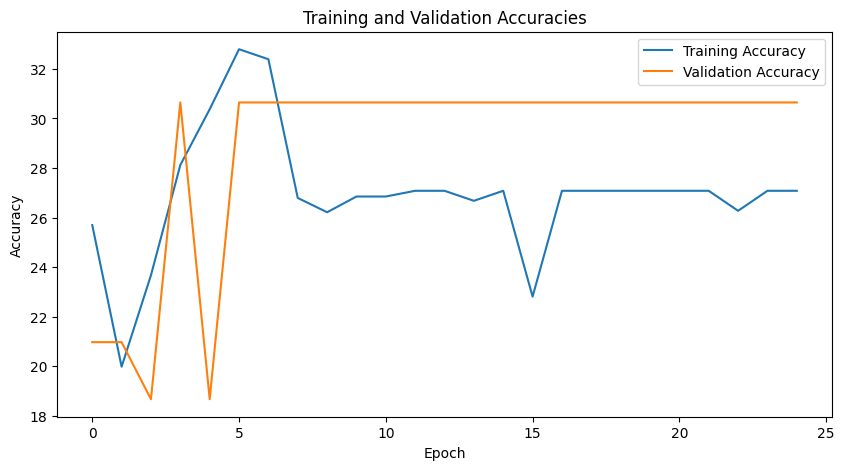

Training on SGD
Epoch [1/100], Train Loss: 1.6532, Val Loss: 1.7639, Train Acc: 37.53, Val Acc: 35.94
Epoch [2/100], Train Loss: 1.2574, Val Loss: 1.5040, Train Acc: 50.92, Val Acc: 39.17
Epoch [3/100], Train Loss: 1.2947, Val Loss: 1.3328, Train Acc: 57.45, Val Acc: 44.70
Epoch [4/100], Train Loss: 1.0413, Val Loss: 1.1625, Train Acc: 69.75, Val Acc: 53.00
Epoch [5/100], Train Loss: 3.7810, Val Loss: 6.0139, Train Acc: 77.31, Val Acc: 20.28
Epoch [6/100], Train Loss: 2.8406, Val Loss: 4.9778, Train Acc: 87.53, Val Acc: 34.10
Epoch [7/100], Train Loss: 2.1605, Val Loss: 2.7244, Train Acc: 94.75, Val Acc: 38.25
Epoch [8/100], Train Loss: 4.2725, Val Loss: 5.9260, Train Acc: 97.52, Val Acc: 31.80
Epoch [9/100], Train Loss: 1.3483, Val Loss: 1.6025, Train Acc: 97.17, Val Acc: 55.07
Epoch [10/100], Train Loss: 1.3187, Val Loss: 2.4620, Train Acc: 99.02, Val Acc: 50.69
Epoch [11/100], Train Loss: 1.2872, Val Loss: 2.3701, Train Acc: 99.48, Val Acc: 47.70
Epoch [12/100], Train Loss: 1.3198, 

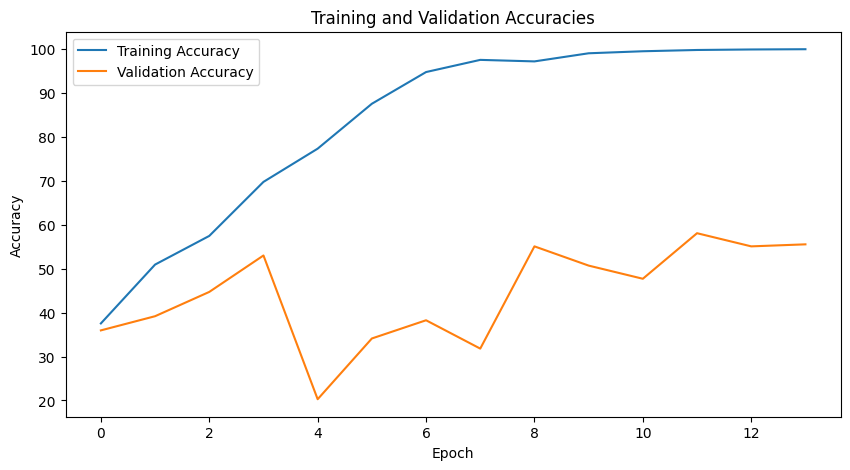

Training on AdaGrad
Epoch [1/100], Train Loss: 1.6008, Val Loss: 1.6350, Train Acc: 23.44, Val Acc: 30.65
Epoch [2/100], Train Loss: 1.5930, Val Loss: 1.5811, Train Acc: 27.31, Val Acc: 30.65
Epoch [3/100], Train Loss: 1.5246, Val Loss: 1.5882, Train Acc: 25.69, Val Acc: 30.65
Epoch [4/100], Train Loss: 1.5928, Val Loss: 1.6406, Train Acc: 26.21, Val Acc: 18.66
Epoch [5/100], Train Loss: 1.5484, Val Loss: 1.5806, Train Acc: 26.91, Val Acc: 30.65
Epoch [6/100], Train Loss: 1.7634, Val Loss: 1.7029, Train Acc: 28.75, Val Acc: 18.66
Epoch [7/100], Train Loss: 1.4703, Val Loss: 1.5960, Train Acc: 27.48, Val Acc: 30.65
Epoch [8/100], Train Loss: 2.6317, Val Loss: 2.5702, Train Acc: 30.48, Val Acc: 18.66
Epoch [9/100], Train Loss: 1.9284, Val Loss: 1.9995, Train Acc: 31.93, Val Acc: 30.65
Epoch [10/100], Train Loss: 2.0960, Val Loss: 2.3910, Train Acc: 34.93, Val Acc: 30.65
Epoch [11/100], Train Loss: 2.3017, Val Loss: 2.7720, Train Acc: 36.03, Val Acc: 30.65
Epoch [12/100], Train Loss: 2.26

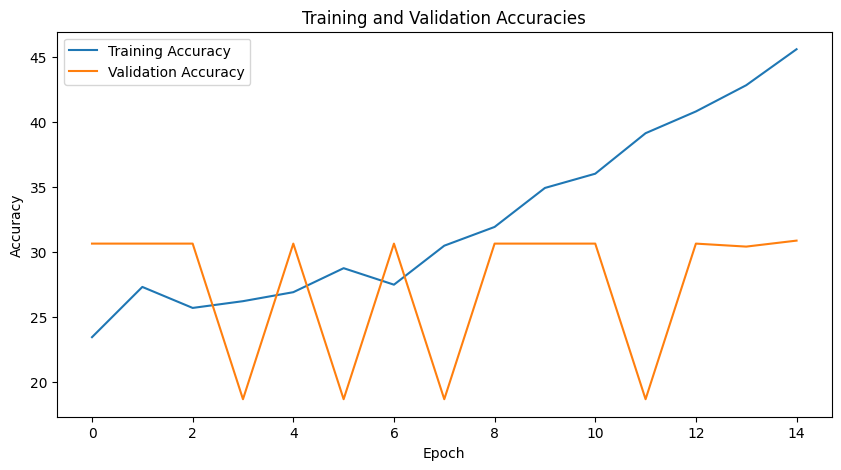

Training on RMSProp
Epoch [1/100], Train Loss: 16.5690, Val Loss: 28.6934, Train Acc: 23.79, Val Acc: 17.74
Epoch [2/100], Train Loss: 13.9197, Val Loss: 14.1891, Train Acc: 27.25, Val Acc: 23.04
Epoch [3/100], Train Loss: 30.9080, Val Loss: 40.1964, Train Acc: 27.66, Val Acc: 19.59
Epoch [4/100], Train Loss: 3.8208, Val Loss: 5.5025, Train Acc: 26.79, Val Acc: 29.03
Epoch [5/100], Train Loss: 183.3219, Val Loss: 238.9006, Train Acc: 25.98, Val Acc: 30.65
Epoch [6/100], Train Loss: 2.1600, Val Loss: 3.7382, Train Acc: 30.37, Val Acc: 26.73
Epoch [7/100], Train Loss: 11.5032, Val Loss: 11.8902, Train Acc: 27.25, Val Acc: 14.75
Epoch [8/100], Train Loss: 1.7073, Val Loss: 1.7372, Train Acc: 25.64, Val Acc: 28.80
Epoch [9/100], Train Loss: 2.0977, Val Loss: 2.1625, Train Acc: 27.14, Val Acc: 30.18
Epoch [10/100], Train Loss: 1.5183, Val Loss: 1.6950, Train Acc: 25.87, Val Acc: 30.65
Epoch [11/100], Train Loss: 2007.1641, Val Loss: 2007.0839, Train Acc: 25.64, Val Acc: 13.13
Epoch [12/100]

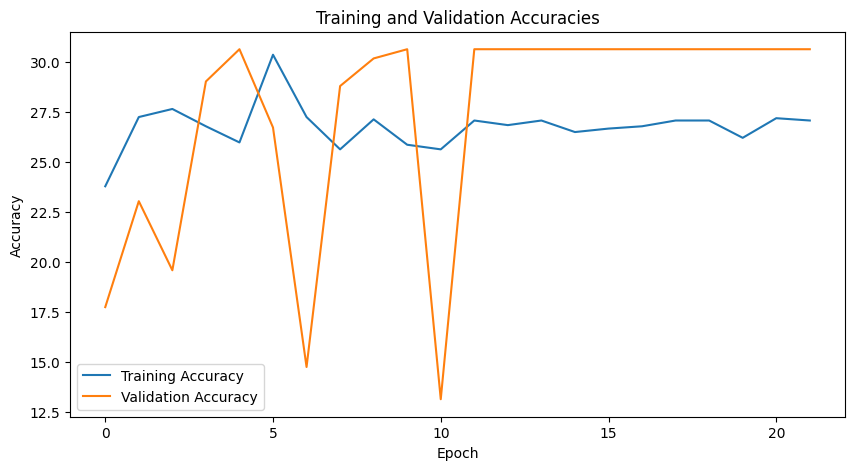

In [12]:
# SGD, AdaGrad, RMSProp,and Adam

def create_optimizers(model):
    optimizers = {
        'Adam': Adam(model.parameters(), lr=0.01, weight_decay=0.001),
        'SGD': SGD(model.parameters(), lr=0.01, weight_decay=0.001),
        'AdaGrad': Adagrad(model.parameters(), lr=0.01, weight_decay=0.001),
        'RMSProp': RMSprop(model.parameters(), lr=0.01, weight_decay=0.001)
    }
    return optimizers

init_opt_model = NeuralNetwork(3)
optimizers = create_optimizers(init_opt_model)
init_opt_model.to(device)

# Optimizers
for opt_name, optimizer in optimizers.items():
    opt_model = deepcopy(init_opt_model)  # Reset model parameters
    optimizers = create_optimizers(opt_model)
    print(f'Training on {opt_name}')
    train_acc, val_acc, _ = train(100, optimizers[opt_name], train_loader, val_loader, opt_model, True)
    plot(train_acc, val_acc)

### STEP 6

In [13]:

def uniform_random_search_hyperparameters(min_lr, max_lr, min_weight_decay, max_weight_decay, num_samples):
    hyperparameters = []
    for _ in range(num_samples):
        # Generate random values for learning rate and weight decay within their respective ranges
        lr = random.uniform(min_lr, max_lr)
        weight_decay = random.uniform(min_weight_decay, max_weight_decay)
        hyperparameters.append((lr, weight_decay))
    return hyperparameters

# Coarse search with min_lr = 0.001 max_lr = 0.01 min_weight_decay = 1e-3 max_weight_decay = 1e-2 and output: lr=0.0023 wd=0.00287
min_lr = 0.002
max_lr = 0.0025
min_weight_decay = 0.0025
max_weight_decay = 0.003
num_samples = 10
hyperparameters = uniform_random_search_hyperparameters(min_lr, max_lr, min_weight_decay, max_weight_decay, num_samples)
print(hyperparameters)

initial_model = NeuralNetwork(3)
initial_model.to(device)

# To keep track of the best model
best_val_loss = float('inf')
best_params = None
# Random Search
for lr, wd in hyperparameters:
    print("Training with params:", lr, wd)
    opt_model = deepcopy(initial_model)
    # Initialize the optimizer with hyperparameters
    optimizer = SGD(opt_model.parameters(), lr=lr, weight_decay=wd)

    _, _, val_loss = train(100, optimizer, train_loader, val_loader, opt_model, True)
    print(f'val loss for {lr}, {wd}: {val_loss}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = {'learning rate': lr,
                       'weight_decay': wd}

print("Best Validation Loss:", best_val_loss)
print("Best Hyperparameters:", best_params)

[(0.0022058081921400817, 0.00276391443576301), (0.0023752806560110125, 0.0025884314786864884), (0.0021282237024452407, 0.0029642489428343115), (0.002203438648264996, 0.002550982328714107), (0.0021408065211081335, 0.0026144718156412843), (0.0020160348833157963, 0.002614331259647795), (0.0020607585135494974, 0.0027226091337958906), (0.0021906660139931855, 0.0026714053229940854), (0.0021385353344585962, 0.0025524867842878093), (0.0024864262916919934, 0.0026281466990369)]
Training with params: 0.0022058081921400817 0.00276391443576301
Epoch [1/100], Train Loss: 1.4276, Val Loss: 1.5062, Train Acc: 33.49, Val Acc: 35.02
Epoch [2/100], Train Loss: 1.5083, Val Loss: 1.7199, Train Acc: 47.06, Val Acc: 36.64
Epoch [3/100], Train Loss: 1.8850, Val Loss: 1.5558, Train Acc: 53.18, Val Acc: 36.87
Epoch [4/100], Train Loss: 1.9638, Val Loss: 1.7951, Train Acc: 57.91, Val Acc: 34.33
Epoch [5/100], Train Loss: 1.0602, Val Loss: 1.1681, Train Acc: 62.76, Val Acc: 50.23
Epoch [6/100], Train Loss: 1.0554

KeyboardInterrupt: 

## Optimal optimizer

New best model saved with validation loss: 1.4962074160575867
Epoch [1/100], Train Loss: 1.4623, Val Loss: 1.4962, Train Acc: 38.16, Val Acc: 43.55
Epoch [2/100], Train Loss: 1.6345, Val Loss: 2.0565, Train Acc: 52.02, Val Acc: 34.33
New best model saved with validation loss: 1.2132489936692374
Epoch [3/100], Train Loss: 0.8278, Val Loss: 1.2132, Train Acc: 57.45, Val Acc: 53.46
New best model saved with validation loss: 1.1124816622052873
Epoch [4/100], Train Loss: 0.8612, Val Loss: 1.1125, Train Acc: 62.59, Val Acc: 55.30
Epoch [5/100], Train Loss: 0.8647, Val Loss: 1.1350, Train Acc: 67.21, Val Acc: 55.53
Epoch [6/100], Train Loss: 1.4370, Val Loss: 1.5293, Train Acc: 72.17, Val Acc: 44.47
Epoch [7/100], Train Loss: 1.4407, Val Loss: 2.6326, Train Acc: 75.52, Val Acc: 36.64
Epoch [8/100], Train Loss: 1.3303, Val Loss: 1.5230, Train Acc: 79.27, Val Acc: 37.56
Epoch [9/100], Train Loss: 2.4222, Val Loss: 2.3528, Train Acc: 83.66, Val Acc: 34.56
Epoch [10/100], Train Loss: 0.5907, Val 

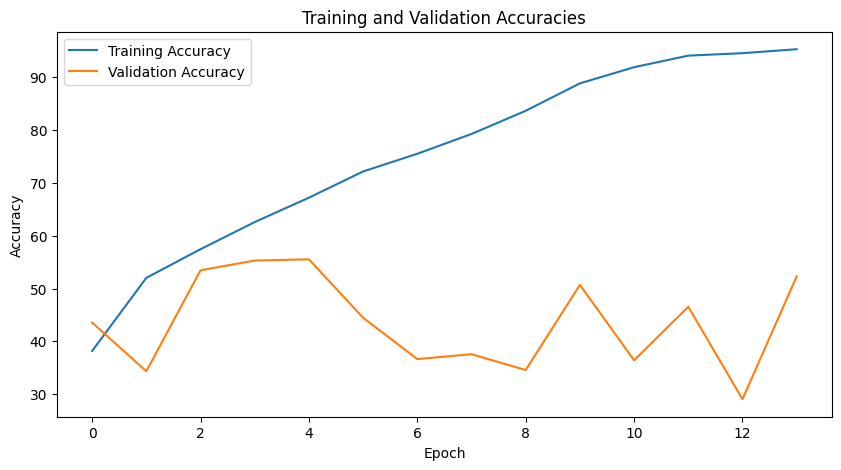

In [17]:
model = NeuralNetwork(3)
model.to(device)

optimizer = SGD(model.parameters(), lr=0.0024, weight_decay=0.00028)
train_acc, val_acc, loss  = train(100, optimizer, train_loader, val_loader, model)
plot(train_acc, val_acc)
torch.save(model.state_dict(), 'model.pth')

In [14]:
# testing
def test(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on test images: {} %'.format(100 * correct / total))

In [16]:
test(model)

Accuracy of the network on test images: 57.0 %


### STEP 7

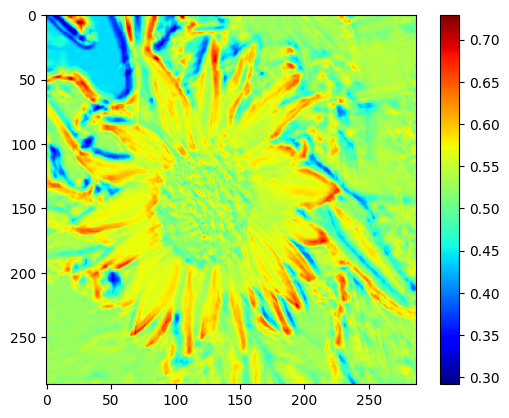

In [25]:
def get_interested_layer_feature_map(model, image):
    model.eval()

    # Register a forward hook to capture the feature map of the desired layer
    activations = []
    def hook_fn(module, input, output):
        activations.append(output)
    model.conv2.register_forward_hook(hook_fn)
    image = image.to(device)
    #apply a batch dimension
    image = image.unsqueeze(0)
    # Forward pass the image through the model
    with torch.no_grad():
        model(image)

    # Get the feature map from the hook
    feature_map = activations[0].squeeze(0)
    return feature_map

# Load a validation input image
for images, labels in val_loader:
    image = images[2]  
    break  


# Get the feature map
feature_map = get_interested_layer_feature_map(model, image)

feature_map_cpu = feature_map.cpu()
feature_map_numpy = feature_map_cpu.detach().numpy()

# Apply normalization (min-max scaling) to the feature map
normalized_feature_map = (feature_map_numpy - feature_map_numpy.min()) / (feature_map_numpy.max() - feature_map_numpy.min())

# Display the heatmap
plt.imshow(normalized_feature_map[0], cmap='jet')
plt.colorbar()
plt.show()

## STEP 8

Epoch [1/30], Train Loss: 1.5218, Val Loss: 1.5365, Train Acc: 35.05, Val Acc: 44.70
Epoch [2/30], Train Loss: 1.4411, Val Loss: 1.4484, Train Acc: 45.44, Val Acc: 50.69
Epoch [3/30], Train Loss: 1.3706, Val Loss: 1.3918, Train Acc: 47.11, Val Acc: 49.77
Epoch [4/30], Train Loss: 1.3174, Val Loss: 1.3456, Train Acc: 47.98, Val Acc: 50.00
Epoch [5/30], Train Loss: 1.2773, Val Loss: 1.3128, Train Acc: 47.81, Val Acc: 51.38
Epoch [6/30], Train Loss: 1.2417, Val Loss: 1.2758, Train Acc: 49.13, Val Acc: 50.46
Epoch [7/30], Train Loss: 1.2066, Val Loss: 1.2457, Train Acc: 49.31, Val Acc: 51.61
Epoch [8/30], Train Loss: 1.1665, Val Loss: 1.2348, Train Acc: 50.29, Val Acc: 52.53
Epoch [9/30], Train Loss: 1.1555, Val Loss: 1.2109, Train Acc: 50.17, Val Acc: 53.46
Epoch [10/30], Train Loss: 1.1256, Val Loss: 1.1824, Train Acc: 51.50, Val Acc: 53.46
Epoch [11/30], Train Loss: 1.1093, Val Loss: 1.1960, Train Acc: 51.56, Val Acc: 53.46
Epoch [12/30], Train Loss: 1.1854, Val Loss: 1.2856, Train Acc:

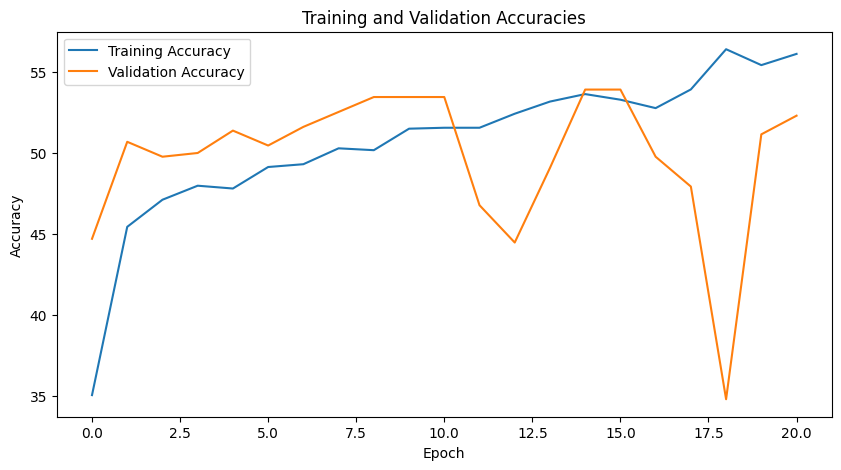

In [24]:
class ImprovedNeuralNetwork(nn.Module):
    def __init__(self, input_channels):
        super(ImprovedNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 7, stride=1, padding=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(p=0.4)
        self.conv4 = nn.Conv2d(128, 256, 5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(256)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
imporved_model = ImprovedNeuralNetwork(3)
imporved_model.to(device)
optimizer = SGD(imporved_model.parameters(), lr=0.0024, weight_decay=0.00028)
t_acc, v_acc, _ = train(30, optimizer, train_loader, val_loader, imporved_model)

plot(t_acc, v_acc)
torch.save(model.state_dict(), 'imporved_model.pth')

In [27]:
t_acc, v_acc, _ = train(10, optimizer, train_loader, val_loader, imporved_model)

Epoch [1/10], Train Loss: 0.9727, Val Loss: 1.0997, Train Acc: 57.27, Val Acc: 53.46
Epoch [2/10], Train Loss: 1.0929, Val Loss: 1.1714, Train Acc: 56.76, Val Acc: 54.61
Epoch [3/10], Train Loss: 1.2429, Val Loss: 1.3548, Train Acc: 57.91, Val Acc: 52.07
Epoch [4/10], Train Loss: 1.0004, Val Loss: 1.2370, Train Acc: 58.49, Val Acc: 52.76
Epoch [5/10], Train Loss: 0.9413, Val Loss: 1.0993, Train Acc: 58.78, Val Acc: 54.15
Epoch [6/10], Train Loss: 1.5227, Val Loss: 1.5450, Train Acc: 58.60, Val Acc: 45.39
Epoch [7/10], Train Loss: 1.1213, Val Loss: 1.1470, Train Acc: 59.18, Val Acc: 52.76
Epoch [8/10], Train Loss: 1.1353, Val Loss: 1.2079, Train Acc: 59.53, Val Acc: 51.15
Epoch [9/10], Train Loss: 1.0729, Val Loss: 1.1746, Train Acc: 59.58, Val Acc: 55.99
Epoch [10/10], Train Loss: 1.6701, Val Loss: 1.6115, Train Acc: 60.62, Val Acc: 37.56
Early stopping. Stop training.


### Eliminated the overfitting but did not improve the test accuracy
### Overall a better model because it does not overfit

In [28]:
test(imporved_model)

Accuracy of the network on test images: 44.75 %


# Part Two

## STEP ONE

In [19]:
vgg16 = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

new_fc1 = nn.Linear(25088, 1024)
classifier = nn.Sequential(
    new_fc1,
    nn.ReLU(inplace=True),
    model.fc2,
    nn.ReLU(inplace=True),
    model.fc3
)

vgg16.classifier = classifier

# Freeze all layers
for param in vgg16.parameters():
    param.requires_grad = False

# Unfreeze the custom classifier layers
for param in vgg16.classifier.parameters():
    param.requires_grad = True

vgg16.to(device)
optimizer = SGD(vgg16.parameters(), lr=0.001)
train(100, optimizer, train_loader, val_loader, vgg16)

test(vgg16)

New best model saved with validation loss: 1.5005797232900346
Epoch [1/100], Train Loss: 1.4925, Val Loss: 1.5006, Train Acc: 43.94, Val Acc: 51.61
New best model saved with validation loss: 1.3721182601792472
Epoch [2/100], Train Loss: 1.3625, Val Loss: 1.3721, Train Acc: 61.66, Val Acc: 64.75
New best model saved with validation loss: 1.2356768165315901
Epoch [3/100], Train Loss: 1.2533, Val Loss: 1.2357, Train Acc: 69.69, Val Acc: 69.35
New best model saved with validation loss: 1.1079862117767334
Epoch [4/100], Train Loss: 1.1557, Val Loss: 1.1080, Train Acc: 73.04, Val Acc: 71.20
New best model saved with validation loss: 0.9973158027444567
Epoch [5/100], Train Loss: 1.0611, Val Loss: 0.9973, Train Acc: 77.08, Val Acc: 74.88
New best model saved with validation loss: 0.9129941506045205
Epoch [6/100], Train Loss: 0.9917, Val Loss: 0.9130, Train Acc: 80.25, Val Acc: 76.96
New best model saved with validation loss: 0.8396241196564266
Epoch [7/100], Train Loss: 0.9317, Val Loss: 0.839

In [20]:
torch.save(vgg16.state_dict(), 'vgg16.pth')

### STEP TWO

In [21]:
inception_v3 = models.inception_v3(weights='DEFAULT')  
inception_v3.to(device)
test(inception_v3)

optimizer = SGD(inception_v3.parameters(), lr=0.001)
def inception_train():
  num_epochs = 20
  for epoch in range(num_epochs):  
      inception_v3.train()
      running_loss = 0.0
      correct = 0
      total = 0
      
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          # Forward pass
          outputs, aux_outputs = inception_v3(inputs)
          loss1 = criterion(outputs, labels)
          loss2 = criterion(aux_outputs, labels)
          loss = loss1 + 0.4 * loss2

          # Backward and optimize
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          # Calculate accuracy
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      epoch_loss = running_loss / len(train_loader)
      epoch_acc = 100 * correct / total

      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    
# Freeze all layers
for param in inception_v3.parameters():
    param.requires_grad = False

# Unfreeze the last two layers
for param in inception_v3.dropout.parameters():
    param.requires_grad = True
for param in inception_v3.fc.parameters():
    param.requires_grad = True
    
inception_train()
test(inception_v3)


# Unfreeze all layers
for param in inception_v3.parameters():
    param.requires_grad = True
    
inception_train()
test(inception_v3)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 316MB/s] 


Accuracy of the network on test images: 0.0 %
Epoch [1/20], Loss: 10.2479, Accuracy: 0.40%
Epoch [2/20], Loss: 8.2598, Accuracy: 5.95%
Epoch [3/20], Loss: 6.8219, Accuracy: 19.63%
Epoch [4/20], Loss: 6.0201, Accuracy: 25.00%
Epoch [5/20], Loss: 5.5949, Accuracy: 30.72%
Epoch [6/20], Loss: 5.3341, Accuracy: 33.66%
Epoch [7/20], Loss: 5.1775, Accuracy: 36.09%
Epoch [8/20], Loss: 5.0834, Accuracy: 39.38%
Epoch [9/20], Loss: 4.9953, Accuracy: 43.13%
Epoch [10/20], Loss: 4.8978, Accuracy: 46.30%
Epoch [11/20], Loss: 4.8253, Accuracy: 49.08%
Epoch [12/20], Loss: 4.8090, Accuracy: 49.54%
Epoch [13/20], Loss: 4.7585, Accuracy: 51.39%
Epoch [14/20], Loss: 4.6984, Accuracy: 53.58%
Epoch [15/20], Loss: 4.6638, Accuracy: 55.54%
Epoch [16/20], Loss: 4.6579, Accuracy: 55.89%
Epoch [17/20], Loss: 4.6008, Accuracy: 57.68%
Epoch [18/20], Loss: 4.5586, Accuracy: 59.47%
Epoch [19/20], Loss: 4.5602, Accuracy: 59.53%
Epoch [20/20], Loss: 4.5041, Accuracy: 61.95%
Accuracy of the network on test images: 65.0

In [22]:
torch.save(inception_v3.state_dict(), 'inception_v3.pth')

# test accuracy
1. 0% no fine-tuning
2. 65% two layer fine-tuning
3. 91% complete fine-tuning
#### as expected the results are far better when fine-tuning the whole network but if data is huge this would not be feasible.